# PD Model Validation

## Change to project directory (google colab)

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
os.chdir('/content/drive/MyDrive/projects/credit-risk-modelling-udemy/notebooks/')
os.listdir('../')

['venv-hpx360-win',
 'data',
 'src',
 '.git',
 'requirements.txt',
 'README.md',
 'src.egg-info',
 'setup.py',
 'notebooks',
 'reports',
 'outputs',
 '.gitignore']

In [3]:
!pip install -e ../.

Obtaining file:///content/drive/MyDrive/projects/credit-risk-modelling-udemy
  Running setup.py develop for src


## Some imports

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import src
from src.project.config import PROJECT_DIR
import json

## Load Data

In [6]:
fpaths = {subset: os.path.join(PROJECT_DIR, 'outputs', f'loan_data_2007_2014_{subset}_prepared_for_pd_model_nb3.pkl') for subset in ['train', 'test']}
df_train = pd.read_pickle(fpaths['train'])
df_test = pd.read_pickle(fpaths['test'])


In [7]:
infile = '../outputs/dummy_vars_ref_cats.json'
with open(infile, 'r') as f:
    d = json.load(f)

DUMMY_VARIABLES = d['DUMMY_VARIABLES']
REFERENCE_CATEGORIES = d['REFERENCE_CATEGORIES']


## Load Model

In [10]:
from src.models import LogisticRegressionWithPValues # needed to load pickled model correctly

In [9]:
import pickle

infile = os.path.join(PROJECT_DIR, 'outputs', 'pd_model_logreg.pkl')
with open(infile, 'rb') as f:
    clf = pickle.load(f)
clf

LogisticRegressionWithPValues(C=1.0, class_weight=None, dual=False,
                              fit_intercept=True, intercept_scaling=1,
                              l1_ratio=None, max_iter=100, multi_class='auto',
                              n_jobs=None, penalty='l2', random_state=None,
                              solver='saga', tol=0.0001, verbose=0,
                              warm_start=False)

## Prepare $X$ and $y$

In [11]:
X_train, y_train = df_train[DUMMY_VARIABLES], df_train['good_bad_loan'].to_numpy().astype(int)
X_test, y_test = df_test[DUMMY_VARIABLES], df_test['good_bad_loan'].to_numpy().astype(int)

## Validation on the test set

In [59]:
THRESHOLD = 0.85

In [60]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

In [61]:
y_test_pred_prob = clf.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_pred_prob > THRESHOLD).astype(int)

In [62]:
print(classification_report(y_test, y_test_pred, target_names=['DEFAULT', 'NON-DEFAULT']))

              precision    recall  f1-score   support

     DEFAULT       0.21      0.47      0.29     10427
 NON-DEFAULT       0.92      0.78      0.84     82830

    accuracy                           0.74     93257
   macro avg       0.57      0.62      0.57     93257
weighted avg       0.84      0.74      0.78     93257



In [63]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
fpr, tpr, thresholds

(array([0.       , 0.       , 0.       , ..., 0.9999041, 0.9999041,
        1.       ]),
 array([0.00000000e+00, 1.20729204e-05, 1.81093807e-04, ...,
        9.99987927e-01, 1.00000000e+00, 1.00000000e+00]),
 array([1.98909677, 0.98909677, 0.98791417, ..., 0.47149493, 0.46640476,
        0.46611612]))

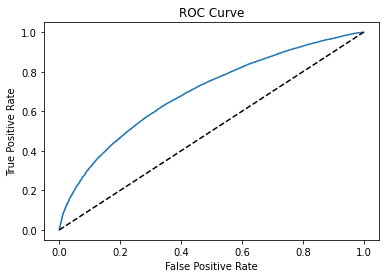

In [64]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle='--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve');

In [65]:
auc = roc_auc_score(y_test, y_test_pred)
auc

0.6233648362801645

## Kolmogorov Smirnov Test

* Comparing two probability distributions

In [86]:
df_actual_predicted_probs = pd.DataFrame({'true': y_test, 'pred': y_test_pred, 'pred_prob': y_test_pred_prob}).sort_values('pred_prob').reset_index(drop=True)
df_actual_predicted_probs

,true,pred,pred_prob
0,0,0,0.466116
1,1,0,0.466405
2,0,0,0.471495
3,0,0,0.489040
4,0,0,0.494749
...,...,...,...
93252,1,1,0.988362
93253,1,1,0.988489
93254,1,1,0.988535
93255,1,1,0.988646


In [87]:
df_actual_predicted_probs['cumulative_n_pop'] = df_actual_predicted_probs.index + 1
df_actual_predicted_probs['cumulative_n_good'] = df_actual_predicted_probs['true'].cumsum()
df_actual_predicted_probs['cumulative_n_bad'] = df_actual_predicted_probs['cumulative_n_pop'] - df_actual_predicted_probs['cumulative_n_good']

df_actual_predicted_probs


,true,pred,pred_prob,cumulative_n_pop,cumulative_n_good,cumulative_n_bad
0,0,0,0.466116,1,0,1
1,1,0,0.466405,2,1,1
2,0,0,0.471495,3,1,2
3,0,0,0.489040,4,1,3
4,0,0,0.494749,5,1,4
...,...,...,...,...,...,...
93252,1,1,0.988362,93253,82826,10427
93253,1,1,0.988489,93254,82827,10427
93254,1,1,0.988535,93255,82828,10427
93255,1,1,0.988646,93256,82829,10427


In [88]:
df_actual_predicted_probs['cumulative_perc_pop'] = df_actual_predicted_probs['cumulative_n_pop']/df_actual_predicted_probs.shape[0]
df_actual_predicted_probs['cumulative_perc_good'] = df_actual_predicted_probs['cumulative_n_good']/df_actual_predicted_probs['true'].sum()
df_actual_predicted_probs['cumulative_perc_bad'] = df_actual_predicted_probs['cumulative_n_bad']/(df_actual_predicted_probs.shape[0] - df_actual_predicted_probs['true'].sum())

In [89]:
df_actual_predicted_probs

,true,pred,pred_prob,cumulative_n_pop,cumulative_n_good,cumulative_n_bad,cumulative_perc_pop,cumulative_perc_good,cumulative_perc_bad
0,0,0,0.466116,1,0,1,0.000011,0.000000,0.000096
1,1,0,0.466405,2,1,1,0.000021,0.000012,0.000096
2,0,0,0.471495,3,1,2,0.000032,0.000012,0.000192
3,0,0,0.489040,4,1,3,0.000043,0.000012,0.000288
4,0,0,0.494749,5,1,4,0.000054,0.000012,0.000384
...,...,...,...,...,...,...,...,...,...
93252,1,1,0.988362,93253,82826,10427,0.999957,0.999952,1.000000
93253,1,1,0.988489,93254,82827,10427,0.999968,0.999964,1.000000
93254,1,1,0.988535,93255,82828,10427,0.999979,0.999976,1.000000
93255,1,1,0.988646,93256,82829,10427,0.999989,0.999988,1.000000


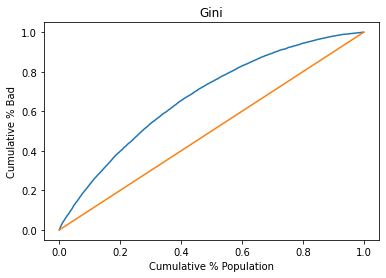

In [90]:
plt.plot(df_actual_predicted_probs['cumulative_perc_pop'], df_actual_predicted_probs['cumulative_perc_bad'])
plt.plot(df_actual_predicted_probs['cumulative_perc_pop'], df_actual_predicted_probs['cumulative_perc_pop'])
plt.xlabel('Cumulative % Population')
plt.ylabel('Cumulative % Bad')
plt.title('Gini');

In [91]:
gini = auc*2 - 1
gini 

0.24672967256032896

In [102]:
diff = (df_actual_predicted_probs['cumulative_perc_bad'] -  df_actual_predicted_probs['cumulative_perc_good'])
max_diff_idx = diff.argmax()
ks_statistic = diff[max_diff_idx]
ks_statistic

0.2873856148102024

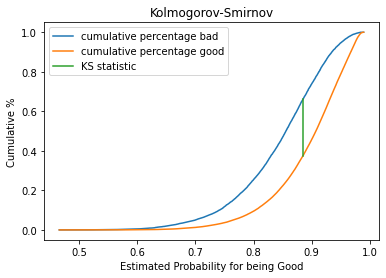

In [107]:
plt.plot(df_actual_predicted_probs['pred_prob'], df_actual_predicted_probs['cumulative_perc_bad'], label='cumulative percentage bad')
plt.plot(df_actual_predicted_probs['pred_prob'], df_actual_predicted_probs['cumulative_perc_good'], label='cumulative percentage good')

x = df_actual_predicted_probs['pred_prob'].iloc[max_diff_idx]
y1 = df_actual_predicted_probs['cumulative_perc_good'].iloc[max_diff_idx]
y2 = df_actual_predicted_probs['cumulative_perc_bad'].iloc[max_diff_idx]
plt.plot([x, x], [y1, y2], label='KS statistic')

plt.xlabel('Estimated Probability for being Good')
plt.ylabel('Cumulative %')
plt.title('Kolmogorov-Smirnov')
plt.legend();
